<a href="https://colab.research.google.com/github/WeizmannML/course2020/blob/master/Tutorial2/NeuralNetwork_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taken from <br> https://towardsdatascience.com/how-to-build-a-diy-deep-learning-framework-in-numpy-59b5b618f9b7 <br> https://github.com/cosmic-cortex/neural-networks-from-scratch

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

## A neural network is a function <font color=green>$f_{\theta}$</font>, takes a data  <font color=green>$\vec{X}$</font> as input and gives the output <font color=green>$\hat{y} = \sigma \Big( f_{\theta}(\vec{X}) \Big)$</font>. <br> <font color=green>$f_{\theta}$</font>  has to be differentianle w.r.t <font color=green>$\theta$</font>. <br> <font color=green> $\sigma( ~. )$ </font> has to be differentiable as well.

In [2]:
class Function:
    """
    Abstract model of a differentiable function.
    """
    def __init__(self, *args, **kwargs):
        # initializing cache for intermediate results
        # helps with gradient calculation in some cases
        self.cache = {}
        # cache for gradients
        self.grad = {}

    def __call__(self, *args, **kwargs):
        # calculating output
        output = self.forward(*args, **kwargs)
        # calculating and caching local gradients
        self.grad = self.local_grad(*args, **kwargs)
        return output

    def forward(self, *args, **kwargs):
        """
        Forward pass of the function. Calculates the output value and the
        gradient at the input as well.
        """
        pass

    def backward(self, *args, **kwargs):
        """
        Backward pass. Computes the local gradient at the input value
        after forward pass.
        """
        pass

    def local_grad(self, *args, **kwargs):
        """
        Calculates the local gradients of the function at the given input.
        Returns:
            grad: dictionary of local gradients.
        """
        pass


## --- note the keyword 'pass'. It means "nothing happens when executed". --> A useful place holder. 
## Later when we will create a Layer or an activation function, inheriting from "Function" class, the 'pass'
## statements will be replaced by appropriate " return .."

### A neural network is built out of several layers. Each layer has its individual weight which are updated via backpropagation. 

In [3]:
class Layer(Function):
    """
    Abstract model of a neural network layer. In addition to Function, a Layer
    also has weights and gradients with respect to the weights.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = {}
        self.weight_update = {}

    def _init_weights(self, *args, **kwargs):
        pass

    def _update_weights(self, lr):
        """
        Updates the weights using the corresponding _global_ gradients computed during
        backpropagation.
        Args:
             lr: float. Learning rate.
        """
        for weight_key, weight in self.weight.items():
            self.weight[weight_key] = self.weight[weight_key] - lr * self.weight_update[weight_key]

            
##-- The 'Layer' inherits from 'Function'. It adds two two new private variables (which are dictionaries),
##   'weight' and 'weight_update'. The weight_update rule has been generally defines as w --> w - lr * grad

### Our neural network will contain multiple 'Linear' layers followed by an 'Activation' layer. <br> The liner layer function <font color=blue>$f_{W,b}$</font> acts on the input data <font color=blue>$X$</font> as <font color=blue>$out = f_{W,b}(X) = WX + b$</font>

In [4]:
class Linear(Layer):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self._init_weights(in_dim, out_dim)

    def _init_weights(self, in_dim, out_dim):
        scale = 1 / np.sqrt(in_dim)
        self.weight['W'] = scale * np.random.randn(in_dim, out_dim)
        self.weight['b'] = scale * np.random.randn(1, out_dim)

    def forward(self, X):
        """
        Forward pass for the Linear layer.
        Args:
            X: numpy.ndarray of shape (n_batch, in_dim) containing
                the input value.
        Returns:
            Y: numpy.ndarray of shape of shape (n_batch, out_dim) containing
                the output value.
        """

        output = np.dot(X, self.weight['W']) + self.weight['b']

        # caching variables for backprop
        self.cache['X'] = X
        self.cache['output'] = output

        return output

    def backward(self, dY):
        """
        Backward pass for the Linear layer.
        Args:
            dY: numpy.ndarray of shape (n_batch, n_out). Global gradient
                backpropagated from the next layer.
        Returns:
            dX: numpy.ndarray of shape (n_batch, n_out). Global gradient
                of the Linear layer.
        """
        # calculating the global gradient, to be propagated backwards
        dX = dY.dot(self.grad['X'].T)
        # calculating the global gradient wrt to weights
        X = self.cache['X']
        dW = self.grad['W'].T.dot(dY)
        db = np.sum(dY, axis=0, keepdims=True)
        # caching the global gradients
        self.weight_update = {'W': dW, 'b': db}

        return dX

    def local_grad(self, X):
        """
        Local gradients of the Linear layer at X.
        Args:
            X: numpy.ndarray of shape (n_batch, in_dim) containing the
                input data.
        Returns:
            grads: dictionary of local gradients with the following items:
                X: numpy.ndarray of shape (n_batch, in_dim).
                W: numpy.ndarray of shape (n_batch, in_dim).
                b: numpy.ndarray of shape (n_batch, 1).
        """
        gradX_local = self.weight['W']
        gradW_local = X
        gradb_local = np.ones_like(self.weight['b'])
        grads = {'X': gradX_local, 'W': gradW_local, 'b': gradb_local}
        return grads

### The activation function : we choose it to be ReLU
#### The activation function doesn't have weights, just the output and gradient, hence will be inherited from 'Function'

In [5]:
def relu(x):
    return x*(x > 0)


def relu_prime(x):
    return 1*(x > 0)

# ----- ReLU ------------------- #
class ReLU(Function):
    def forward(self, X):
        return relu(X)

    def backward(self, dY):
        return dY * self.grad['X']

    def local_grad(self, X):
        grads = {'X': relu_prime(X)}
        return grads

# ------ Softmax won't be use for any gradient descent and hence we don't store the derivatives -- #
class Softmax(Function):
    def forward(self, X):
        exp_x = np.exp(X)
        probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return probs

    def backward(self, dY):
        pass

    def local_grad(self, X):
        pass


In [6]:
class Loss(Function):
    def forward(self, X, Y):
        """
        Computes the loss of x with respect to y.
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            Y: numpy.ndarray of shape (n_batch, n_dim).
        Returns:
            loss: numpy.float.
        """
        pass

    def backward(self):
        """
        Backward pass for the loss function. Since it should be the final layer
        of an architecture, no input is needed for the backward pass.
        Returns:
            gradX: numpy.ndarray of shape (n_batch, n_dim). Local gradient of the loss.
        """
        return self.grad['X']

    def local_grad(self, X, Y):
        """
        Local gradient with respect to X at (X, Y).
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            Y: numpy.ndarray of shape (n_batch, n_dim).
        Returns:
            gradX: numpy.ndarray of shape (n_batch, n_dim).
        """
        pass


### Crossentropy($y,\hat{y}$) = 

In [7]:
class CrossEntropyLoss(Loss):
    def forward(self, X, y):
        """
        Computes the cross entropy loss of x with respect to y.
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            y: numpy.ndarray of shape (n_batch, 1). Should contain class labels
                for each data point in x.
        Returns:
            crossentropy_loss: numpy.float. Cross entropy loss of x with respect to y.
        """
        # calculating crossentropy
        exp_x = np.exp(X)
        probs = exp_x/np.sum(exp_x, axis=1, keepdims=True)
        log_probs = -np.log([probs[i, y[i]] for i in range(len(probs))])
        crossentropy_loss = np.mean(log_probs)

        # caching for backprop
        self.cache['probs'] = probs
        self.cache['y'] = y

        return crossentropy_loss

    def local_grad(self, X, Y):
        probs = self.cache['probs']
        ones = np.zeros_like(probs)
        for row_idx, col_idx in enumerate(Y):
            ones[row_idx, col_idx] = 1.0

        grads = {'X': (probs - ones)/float(len(X))}
        return grads

### Define the neural net

In [8]:
class Net:
    __slots__ = ['layers', 'loss_fn']

    def __init__(self, layers, loss):
        assert isinstance(loss, Loss), 'loss must be an instance of nn.losses.Loss'
        for layer in layers:
            assert isinstance(layer, Function), 'layer should be an instance of ' \
                                                'nn.layers.Function or nn.layers.Layer'

        self.layers = layers
        self.loss_fn = loss

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def forward(self, x):
        """
        Calculates the forward pass by propagating the input through the
        layers.
        Args:
            x: numpy.ndarray. Input of the net.
        Returns:
            output: numpy.ndarray. Output of the net.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def loss(self, x, y):
        """
        Calculates the loss of the forward pass output with respect to y.
        Should be called after forward pass.
        Args:
            x: numpy.ndarray. Output of the forward pass.
            y: numpy.ndarray. Ground truth.
        Returns:
            loss: numpy.float. Loss value.
        """
        loss = self.loss_fn(x, y)
        return loss

    def backward(self):
        """
        Complete backward pass for the net. Should be called after the forward
        pass and the loss are calculated.
        Returns:
            d: numpy.ndarray of shape matching the input during forward pass.
        """
        d = self.loss_fn.backward()
        for layer in reversed(self.layers):
            d = layer.backward(d)
        return d

    def update_weights(self, lr):
        """
        Updates the weights for all layers using the corresponding gradients
        computed during backpropagation.
        Args:
             lr: float. Learning rate.
        """
        for layer in self.layers:
            if isinstance(layer, Layer):
                layer._update_weights(lr)

In [9]:
# functions for visualization
def plot_data(X1, X2, export_path=None):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.scatter(X1[:, 0], X1[:, 1], c='r', edgecolor='k')
        plt.scatter(X2[:, 0], X2[:, 1], c='b', edgecolor='k')
        plt.title('The data')
        if export_path is None:
            plt.show()
        else:
            plt.savefig(export_path, dpi=500)
            
            
def make_grid(X_data, n_res=20):
    x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
    y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
    x_meshgrid, y_meshgrid = np.meshgrid(np.linspace(x_min, x_max, n_res),
                                         np.linspace(y_min, y_max, n_res))

    X_grid = np.concatenate((x_meshgrid.reshape(-1, 1), y_meshgrid.reshape(-1, 1)), axis=1)

    return x_meshgrid, y_meshgrid, X_grid


def plot_classifier(net, X_data, x_meshgrid, y_meshgrid, X_grid, export_path=None):
    y_grid = Softmax()(net(X_grid))[:, 0].reshape(x_meshgrid.shape)
    y_data = net(X_data)
    preds = np.argmax(y_data, axis=1)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.scatter(X_data[preds == 0, 0], X_data[preds == 0, 1], c='b', zorder=1, edgecolor='k')
        plt.scatter(X_data[preds == 1, 0], X_data[preds == 1, 1], c='r', zorder=1, edgecolor='k')
        plt.contourf(x_meshgrid, y_meshgrid, y_grid, zorder=0, cmap='RdBu')
        if not export_path:
            plt.show()
        else:
            plt.savefig(export_path, dpi=500)

        plt.close('all')




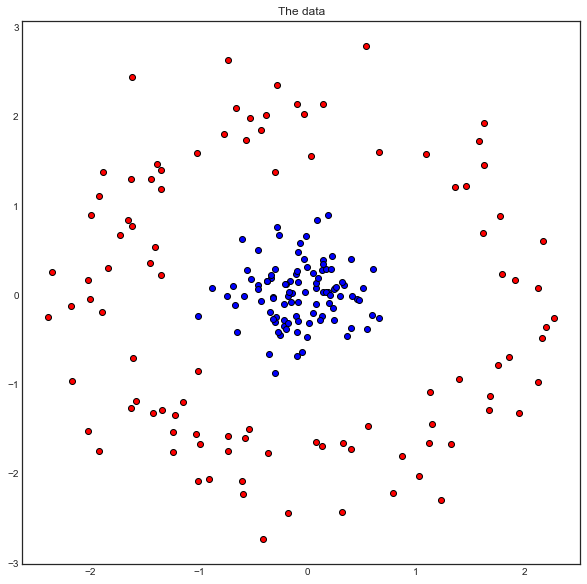

In [10]:
# generating some data
n_class_size = 100
r = 2
X1_offset = np.random.rand(n_class_size, 2) - 0.5
np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1_offset = r * X1_offset/np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size) + X1_offset
X2 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size)

X = np.concatenate((X1, X2))
Y_labels = np.array([0]*n_class_size + [1]*n_class_size)

plot_data(X1, X2)
# make meshgrid
x_meshgrid, y_meshgrid, X_grid = make_grid(X, n_res=100)

Epoch no. 0
accuracy: 0.5000
loss: 1.4844


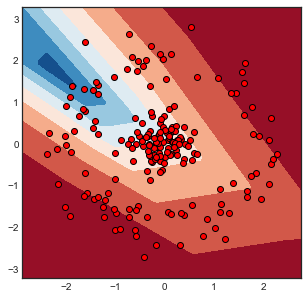

Epoch no. 1
accuracy: 0.5000
loss: 1.3570
Epoch no. 2
accuracy: 0.5000
loss: 1.2491
Epoch no. 3
accuracy: 0.5000
loss: 1.1582
Epoch no. 4
accuracy: 0.5000
loss: 1.0819
Epoch no. 5
accuracy: 0.5000
loss: 1.0179


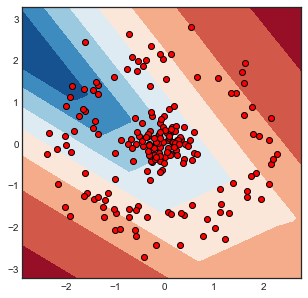

Epoch no. 6
accuracy: 0.5000
loss: 0.9644
Epoch no. 7
accuracy: 0.5000
loss: 0.9195
Epoch no. 8
accuracy: 0.5000
loss: 0.8817
Epoch no. 9
accuracy: 0.5000
loss: 0.8499
Epoch no. 10
accuracy: 0.5000
loss: 0.8230


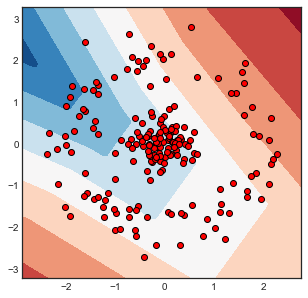

Epoch no. 11
accuracy: 0.5000
loss: 0.8000
Epoch no. 12
accuracy: 0.5050
loss: 0.7803
Epoch no. 13
accuracy: 0.5150
loss: 0.7631
Epoch no. 14
accuracy: 0.5150
loss: 0.7485
Epoch no. 15
accuracy: 0.5200
loss: 0.7358


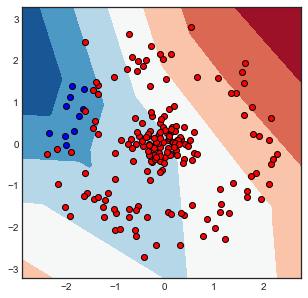

Epoch no. 16
accuracy: 0.5500
loss: 0.7246
Epoch no. 17
accuracy: 0.5700
loss: 0.7148
Epoch no. 18
accuracy: 0.5750
loss: 0.7065
Epoch no. 19
accuracy: 0.6550
loss: 0.6994
Epoch no. 20
accuracy: 0.7200
loss: 0.6930


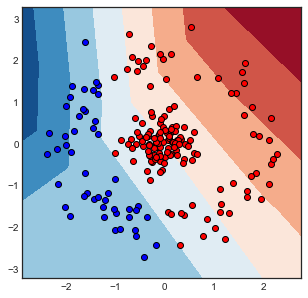

Epoch no. 21
accuracy: 0.7400
loss: 0.6873
Epoch no. 22
accuracy: 0.7400
loss: 0.6822
Epoch no. 23
accuracy: 0.7500
loss: 0.6775
Epoch no. 24
accuracy: 0.7500
loss: 0.6731
Epoch no. 25
accuracy: 0.7500
loss: 0.6690


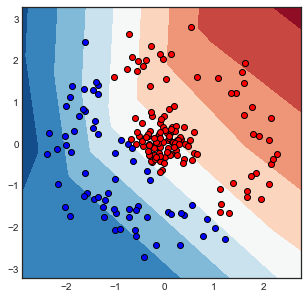

Epoch no. 26
accuracy: 0.7550
loss: 0.6652
Epoch no. 27
accuracy: 0.7450
loss: 0.6616
Epoch no. 28
accuracy: 0.7350
loss: 0.6582
Epoch no. 29
accuracy: 0.7350
loss: 0.6549
Epoch no. 30
accuracy: 0.7200
loss: 0.6516


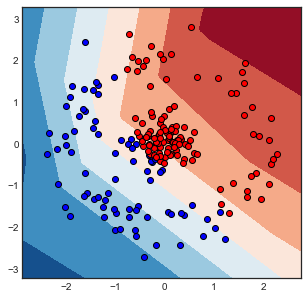

Epoch no. 31
accuracy: 0.7150
loss: 0.6485
Epoch no. 32
accuracy: 0.7050
loss: 0.6454
Epoch no. 33
accuracy: 0.7000
loss: 0.6424
Epoch no. 34
accuracy: 0.7000
loss: 0.6393
Epoch no. 35
accuracy: 0.7000
loss: 0.6364


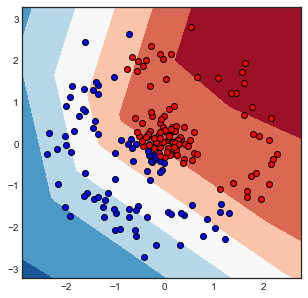

Epoch no. 36
accuracy: 0.7000
loss: 0.6334
Epoch no. 37
accuracy: 0.7000
loss: 0.6305
Epoch no. 38
accuracy: 0.7000
loss: 0.6276
Epoch no. 39
accuracy: 0.7000
loss: 0.6246
Epoch no. 40
accuracy: 0.7100
loss: 0.6216


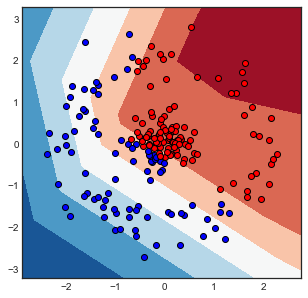

Epoch no. 41
accuracy: 0.7150
loss: 0.6186
Epoch no. 42
accuracy: 0.7150
loss: 0.6156
Epoch no. 43
accuracy: 0.7150
loss: 0.6125
Epoch no. 44
accuracy: 0.7350
loss: 0.6094
Epoch no. 45
accuracy: 0.7350
loss: 0.6062


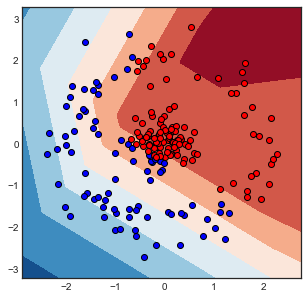

Epoch no. 46
accuracy: 0.7350
loss: 0.6031
Epoch no. 47
accuracy: 0.7450
loss: 0.5998
Epoch no. 48
accuracy: 0.7450
loss: 0.5966
Epoch no. 49
accuracy: 0.7500
loss: 0.5933
Epoch no. 50
accuracy: 0.7550
loss: 0.5899


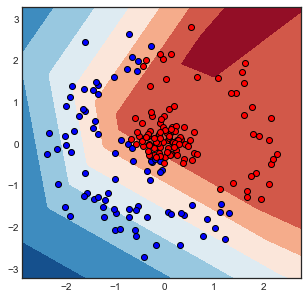

Epoch no. 51
accuracy: 0.7650
loss: 0.5865
Epoch no. 52
accuracy: 0.7800
loss: 0.5830
Epoch no. 53
accuracy: 0.7850
loss: 0.5795
Epoch no. 54
accuracy: 0.8050
loss: 0.5759
Epoch no. 55
accuracy: 0.8050
loss: 0.5723


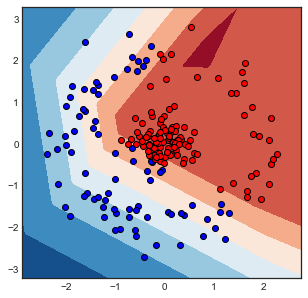

Epoch no. 56
accuracy: 0.8050
loss: 0.5686
Epoch no. 57
accuracy: 0.8050
loss: 0.5649
Epoch no. 58
accuracy: 0.8100
loss: 0.5611
Epoch no. 59
accuracy: 0.8150
loss: 0.5573
Epoch no. 60
accuracy: 0.8150
loss: 0.5535


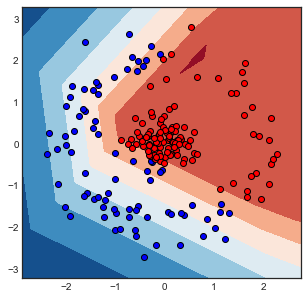

Epoch no. 61
accuracy: 0.8150
loss: 0.5496
Epoch no. 62
accuracy: 0.8150
loss: 0.5457
Epoch no. 63
accuracy: 0.8200
loss: 0.5417
Epoch no. 64
accuracy: 0.8250
loss: 0.5378
Epoch no. 65
accuracy: 0.8300
loss: 0.5337


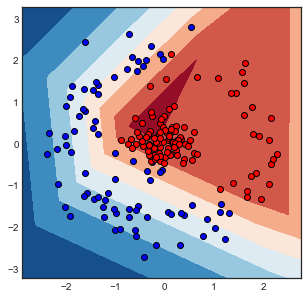

Epoch no. 66
accuracy: 0.8300
loss: 0.5296
Epoch no. 67
accuracy: 0.8400
loss: 0.5255
Epoch no. 68
accuracy: 0.8400
loss: 0.5213
Epoch no. 69
accuracy: 0.8400
loss: 0.5171
Epoch no. 70
accuracy: 0.8400
loss: 0.5129


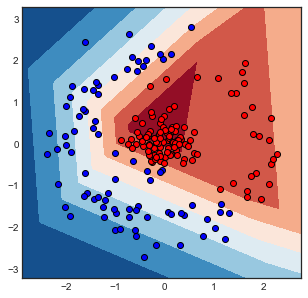

Epoch no. 71
accuracy: 0.8400
loss: 0.5086
Epoch no. 72
accuracy: 0.8400
loss: 0.5043
Epoch no. 73
accuracy: 0.8400
loss: 0.5000
Epoch no. 74
accuracy: 0.8400
loss: 0.4957
Epoch no. 75
accuracy: 0.8400
loss: 0.4913


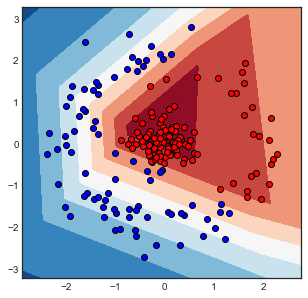

Epoch no. 76
accuracy: 0.8400
loss: 0.4870
Epoch no. 77
accuracy: 0.8400
loss: 0.4826
Epoch no. 78
accuracy: 0.8550
loss: 0.4783
Epoch no. 79
accuracy: 0.8550
loss: 0.4739
Epoch no. 80
accuracy: 0.8650
loss: 0.4695


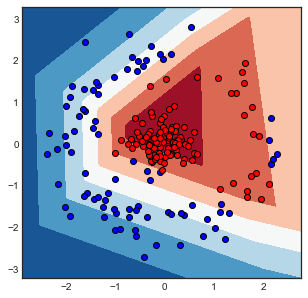

Epoch no. 81
accuracy: 0.8750
loss: 0.4652
Epoch no. 82
accuracy: 0.8800
loss: 0.4608
Epoch no. 83
accuracy: 0.8850
loss: 0.4565
Epoch no. 84
accuracy: 0.8900
loss: 0.4521
Epoch no. 85
accuracy: 0.8900
loss: 0.4478


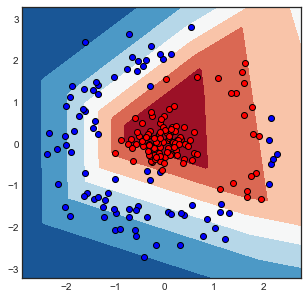

Epoch no. 86
accuracy: 0.8900
loss: 0.4434
Epoch no. 87
accuracy: 0.8950
loss: 0.4391
Epoch no. 88
accuracy: 0.9000
loss: 0.4348
Epoch no. 89
accuracy: 0.9100
loss: 0.4305
Epoch no. 90
accuracy: 0.9200
loss: 0.4262


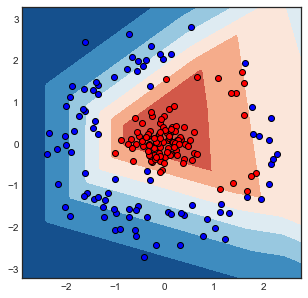

Epoch no. 91
accuracy: 0.9250
loss: 0.4220
Epoch no. 92
accuracy: 0.9350
loss: 0.4178
Epoch no. 93
accuracy: 0.9400
loss: 0.4138
Epoch no. 94
accuracy: 0.9450
loss: 0.4098
Epoch no. 95
accuracy: 0.9450
loss: 0.4058


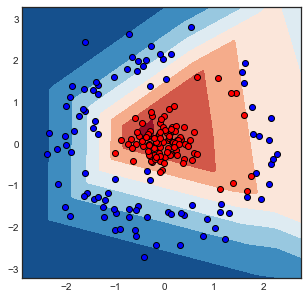

Epoch no. 96
accuracy: 0.9450
loss: 0.4020
Epoch no. 97
accuracy: 0.9450
loss: 0.3981
Epoch no. 98
accuracy: 0.9450
loss: 0.3943
Epoch no. 99
accuracy: 0.9500
loss: 0.3905
Epoch no. 100
accuracy: 0.9500
loss: 0.3866


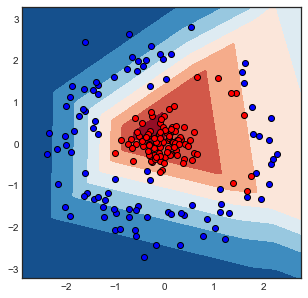

Epoch no. 101
accuracy: 0.9500
loss: 0.3828
Epoch no. 102
accuracy: 0.9500
loss: 0.3790
Epoch no. 103
accuracy: 0.9550
loss: 0.3753
Epoch no. 104
accuracy: 0.9550
loss: 0.3716
Epoch no. 105
accuracy: 0.9550
loss: 0.3679


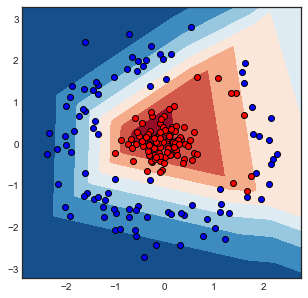

Epoch no. 106
accuracy: 0.9550
loss: 0.3643
Epoch no. 107
accuracy: 0.9550
loss: 0.3607
Epoch no. 108
accuracy: 0.9550
loss: 0.3571
Epoch no. 109
accuracy: 0.9600
loss: 0.3536
Epoch no. 110
accuracy: 0.9650
loss: 0.3501


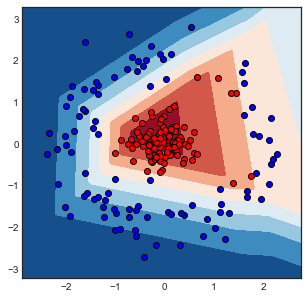

Epoch no. 111
accuracy: 0.9650
loss: 0.3466
Epoch no. 112
accuracy: 0.9650
loss: 0.3431
Epoch no. 113
accuracy: 0.9650
loss: 0.3397
Epoch no. 114
accuracy: 0.9650
loss: 0.3364
Epoch no. 115
accuracy: 0.9650
loss: 0.3330


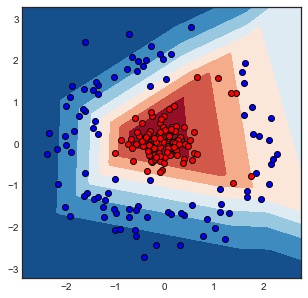

Epoch no. 116
accuracy: 0.9650
loss: 0.3297
Epoch no. 117
accuracy: 0.9650
loss: 0.3264
Epoch no. 118
accuracy: 0.9650
loss: 0.3232
Epoch no. 119
accuracy: 0.9700
loss: 0.3200
Epoch no. 120
accuracy: 0.9700
loss: 0.3167


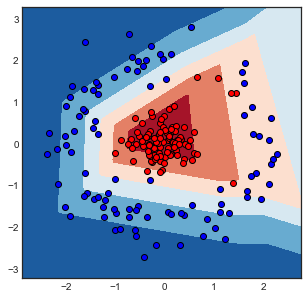

Epoch no. 121
accuracy: 0.9700
loss: 0.3135
Epoch no. 122
accuracy: 0.9750
loss: 0.3104
Epoch no. 123
accuracy: 0.9750
loss: 0.3072
Epoch no. 124
accuracy: 0.9750
loss: 0.3041
Epoch no. 125
accuracy: 0.9750
loss: 0.3011


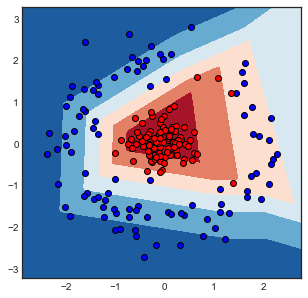

Epoch no. 126
accuracy: 0.9750
loss: 0.2980
Epoch no. 127
accuracy: 0.9750
loss: 0.2950
Epoch no. 128
accuracy: 0.9750
loss: 0.2921
Epoch no. 129
accuracy: 0.9750
loss: 0.2891
Epoch no. 130
accuracy: 0.9750
loss: 0.2862


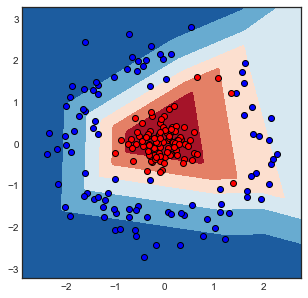

Epoch no. 131
accuracy: 0.9750
loss: 0.2833
Epoch no. 132
accuracy: 0.9750
loss: 0.2804
Epoch no. 133
accuracy: 0.9750
loss: 0.2776
Epoch no. 134
accuracy: 0.9750
loss: 0.2748
Epoch no. 135
accuracy: 0.9750
loss: 0.2720


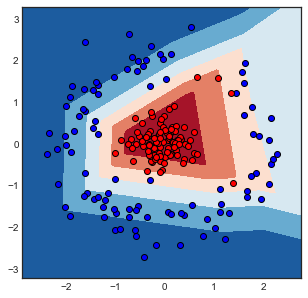

Epoch no. 136
accuracy: 0.9750
loss: 0.2692
Epoch no. 137
accuracy: 0.9750
loss: 0.2664
Epoch no. 138
accuracy: 0.9800
loss: 0.2637
Epoch no. 139
accuracy: 0.9850
loss: 0.2609
Epoch no. 140
accuracy: 0.9850
loss: 0.2583


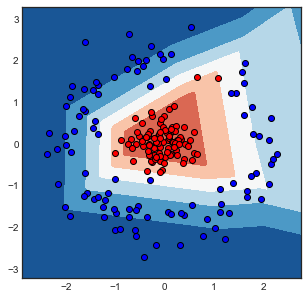

Epoch no. 141
accuracy: 0.9850
loss: 0.2556
Epoch no. 142
accuracy: 0.9850
loss: 0.2529
Epoch no. 143
accuracy: 0.9850
loss: 0.2503
Epoch no. 144
accuracy: 0.9850
loss: 0.2477
Epoch no. 145
accuracy: 0.9850
loss: 0.2452


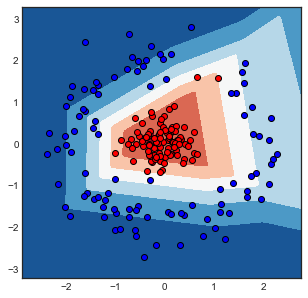

Epoch no. 146
accuracy: 0.9850
loss: 0.2426
Epoch no. 147
accuracy: 0.9850
loss: 0.2401
Epoch no. 148
accuracy: 0.9850
loss: 0.2377
Epoch no. 149
accuracy: 0.9850
loss: 0.2352
Epoch no. 150
accuracy: 0.9850
loss: 0.2328


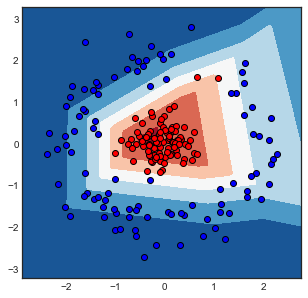

Epoch no. 151
accuracy: 0.9850
loss: 0.2304
Epoch no. 152
accuracy: 0.9850
loss: 0.2280
Epoch no. 153
accuracy: 0.9850
loss: 0.2256
Epoch no. 154
accuracy: 0.9850
loss: 0.2233
Epoch no. 155
accuracy: 0.9900
loss: 0.2210


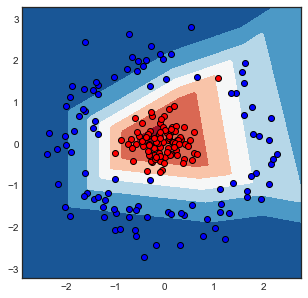

Epoch no. 156
accuracy: 0.9900
loss: 0.2187
Epoch no. 157
accuracy: 0.9900
loss: 0.2164
Epoch no. 158
accuracy: 0.9900
loss: 0.2142
Epoch no. 159
accuracy: 0.9900
loss: 0.2120
Epoch no. 160
accuracy: 0.9900
loss: 0.2098


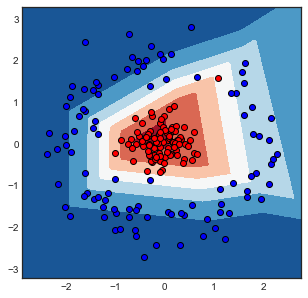

Epoch no. 161
accuracy: 0.9900
loss: 0.2077
Epoch no. 162
accuracy: 0.9900
loss: 0.2055
Epoch no. 163
accuracy: 0.9900
loss: 0.2034
Epoch no. 164
accuracy: 0.9900
loss: 0.2013
Epoch no. 165
accuracy: 0.9900
loss: 0.1992


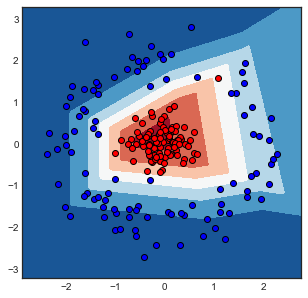

Epoch no. 166
accuracy: 0.9900
loss: 0.1972
Epoch no. 167
accuracy: 0.9900
loss: 0.1952
Epoch no. 168
accuracy: 0.9900
loss: 0.1932
Epoch no. 169
accuracy: 0.9950
loss: 0.1912
Epoch no. 170
accuracy: 0.9950
loss: 0.1893


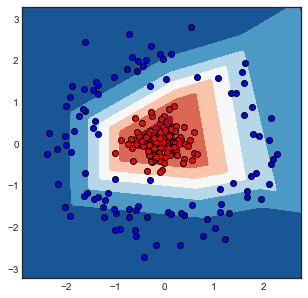

Epoch no. 171
accuracy: 0.9950
loss: 0.1874
Epoch no. 172
accuracy: 0.9950
loss: 0.1855
Epoch no. 173
accuracy: 0.9950
loss: 0.1837
Epoch no. 174
accuracy: 0.9950
loss: 0.1819
Epoch no. 175
accuracy: 0.9950
loss: 0.1801


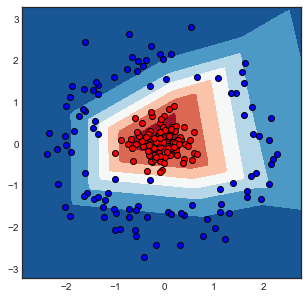

Epoch no. 176
accuracy: 0.9950
loss: 0.1783
Epoch no. 177
accuracy: 0.9950
loss: 0.1765
Epoch no. 178
accuracy: 0.9950
loss: 0.1748
Epoch no. 179
accuracy: 0.9950
loss: 0.1731
Epoch no. 180
accuracy: 0.9950
loss: 0.1714


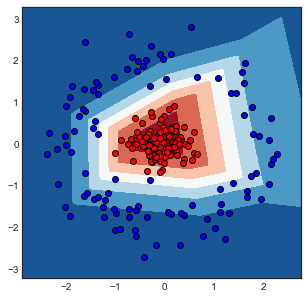

Epoch no. 181
accuracy: 0.9950
loss: 0.1698
Epoch no. 182
accuracy: 0.9950
loss: 0.1681
Epoch no. 183
accuracy: 0.9950
loss: 0.1665
Epoch no. 184
accuracy: 0.9950
loss: 0.1649
Epoch no. 185
accuracy: 0.9950
loss: 0.1634


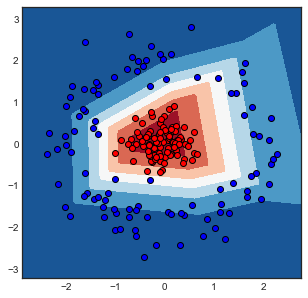

Epoch no. 186
accuracy: 0.9950
loss: 0.1618
Epoch no. 187
accuracy: 0.9950
loss: 0.1603
Epoch no. 188
accuracy: 0.9950
loss: 0.1588
Epoch no. 189
accuracy: 0.9950
loss: 0.1573
Epoch no. 190
accuracy: 0.9950
loss: 0.1559


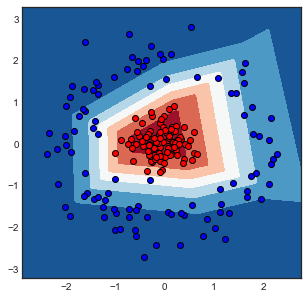

Epoch no. 191
accuracy: 0.9950
loss: 0.1544
Epoch no. 192
accuracy: 0.9950
loss: 0.1530
Epoch no. 193
accuracy: 0.9950
loss: 0.1516
Epoch no. 194
accuracy: 0.9950
loss: 0.1503
Epoch no. 195
accuracy: 0.9950
loss: 0.1489


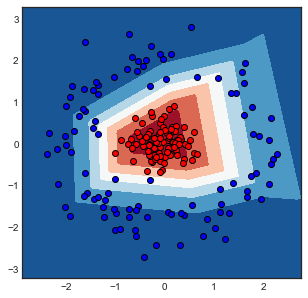

Epoch no. 196
accuracy: 0.9950
loss: 0.1476
Epoch no. 197
accuracy: 0.9950
loss: 0.1463
Epoch no. 198
accuracy: 0.9950
loss: 0.1450
Epoch no. 199
accuracy: 0.9950
loss: 0.1437
Epoch no. 200
accuracy: 0.9950
loss: 0.1424


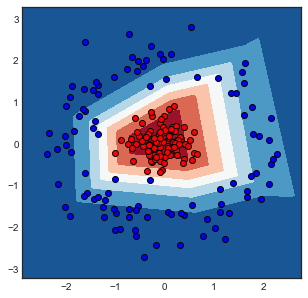

Epoch no. 201
accuracy: 0.9950
loss: 0.1412
Epoch no. 202
accuracy: 0.9950
loss: 0.1400
Epoch no. 203
accuracy: 0.9950
loss: 0.1388
Epoch no. 204
accuracy: 0.9950
loss: 0.1376
Epoch no. 205
accuracy: 0.9950
loss: 0.1364


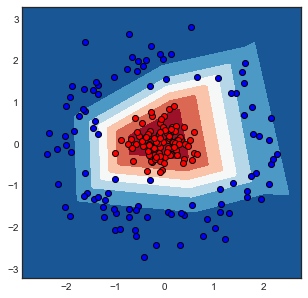

Epoch no. 206
accuracy: 0.9950
loss: 0.1353
Epoch no. 207
accuracy: 0.9950
loss: 0.1341
Epoch no. 208
accuracy: 0.9950
loss: 0.1330
Epoch no. 209
accuracy: 0.9950
loss: 0.1319
Epoch no. 210
accuracy: 0.9950
loss: 0.1308


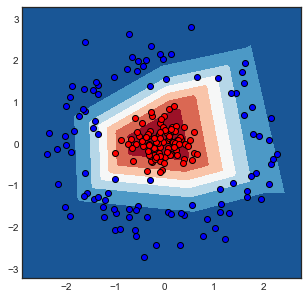

Epoch no. 211
accuracy: 0.9950
loss: 0.1297
Epoch no. 212
accuracy: 0.9950
loss: 0.1287
Epoch no. 213
accuracy: 0.9950
loss: 0.1276
Epoch no. 214
accuracy: 0.9950
loss: 0.1266
Epoch no. 215
accuracy: 0.9950
loss: 0.1256


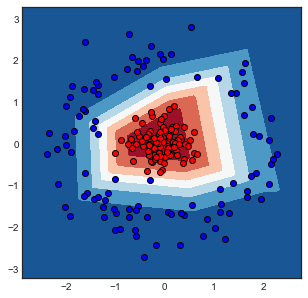

Epoch no. 216
accuracy: 0.9950
loss: 0.1246
Epoch no. 217
accuracy: 1.0000
loss: 0.1236
Epoch no. 218
accuracy: 1.0000
loss: 0.1227
Epoch no. 219
accuracy: 1.0000
loss: 0.1217
Epoch no. 220
accuracy: 1.0000
loss: 0.1208


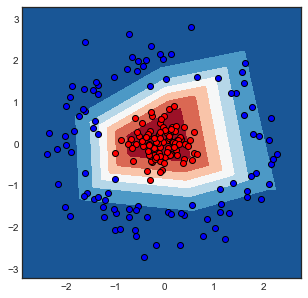

Epoch no. 221
accuracy: 1.0000
loss: 0.1199
Epoch no. 222
accuracy: 1.0000
loss: 0.1190
Epoch no. 223
accuracy: 1.0000
loss: 0.1181
Epoch no. 224
accuracy: 1.0000
loss: 0.1172
Epoch no. 225
accuracy: 1.0000
loss: 0.1163


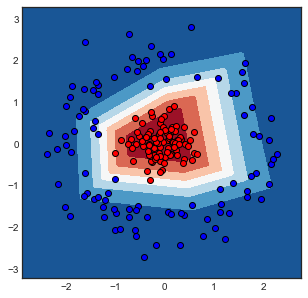

Epoch no. 226
accuracy: 1.0000
loss: 0.1155
Epoch no. 227
accuracy: 1.0000
loss: 0.1146
Epoch no. 228
accuracy: 1.0000
loss: 0.1138
Epoch no. 229
accuracy: 1.0000
loss: 0.1129
Epoch no. 230
accuracy: 1.0000
loss: 0.1121


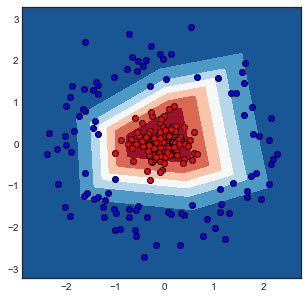

Epoch no. 231
accuracy: 1.0000
loss: 0.1113
Epoch no. 232
accuracy: 1.0000
loss: 0.1105
Epoch no. 233
accuracy: 1.0000
loss: 0.1097
Epoch no. 234
accuracy: 1.0000
loss: 0.1090
Epoch no. 235
accuracy: 1.0000
loss: 0.1082


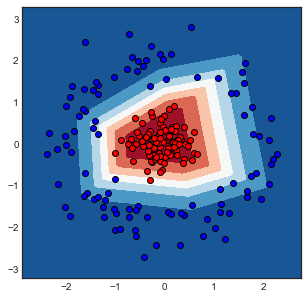

Epoch no. 236
accuracy: 1.0000
loss: 0.1074
Epoch no. 237
accuracy: 1.0000
loss: 0.1067
Epoch no. 238
accuracy: 1.0000
loss: 0.1060
Epoch no. 239
accuracy: 1.0000
loss: 0.1052
Epoch no. 240
accuracy: 1.0000
loss: 0.1045


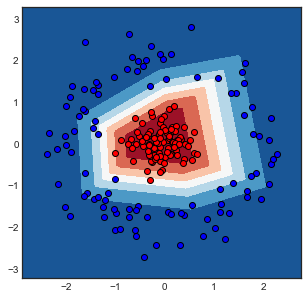

Epoch no. 241
accuracy: 1.0000
loss: 0.1038
Epoch no. 242
accuracy: 1.0000
loss: 0.1031
Epoch no. 243
accuracy: 1.0000
loss: 0.1024
Epoch no. 244
accuracy: 1.0000
loss: 0.1017
Epoch no. 245
accuracy: 1.0000
loss: 0.1011


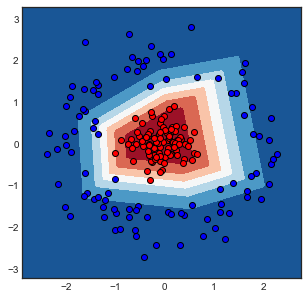

Epoch no. 246
accuracy: 1.0000
loss: 0.1004
Epoch no. 247
accuracy: 1.0000
loss: 0.0997
Epoch no. 248
accuracy: 1.0000
loss: 0.0991
Epoch no. 249
accuracy: 1.0000
loss: 0.0985
Epoch no. 250
accuracy: 1.0000
loss: 0.0978


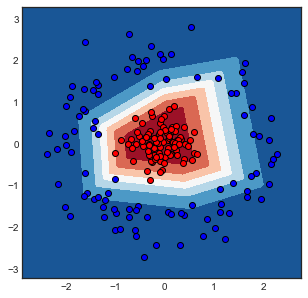

Epoch no. 251
accuracy: 1.0000
loss: 0.0972
Epoch no. 252
accuracy: 1.0000
loss: 0.0966
Epoch no. 253
accuracy: 1.0000
loss: 0.0960
Epoch no. 254
accuracy: 1.0000
loss: 0.0954
Epoch no. 255
accuracy: 1.0000
loss: 0.0948


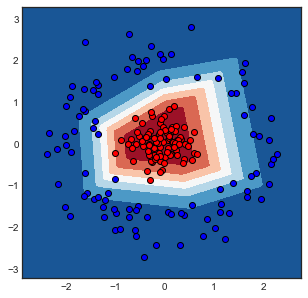

Epoch no. 256
accuracy: 1.0000
loss: 0.0942
Epoch no. 257
accuracy: 1.0000
loss: 0.0936
Epoch no. 258
accuracy: 1.0000
loss: 0.0931
Epoch no. 259
accuracy: 1.0000
loss: 0.0925
Epoch no. 260
accuracy: 1.0000
loss: 0.0919


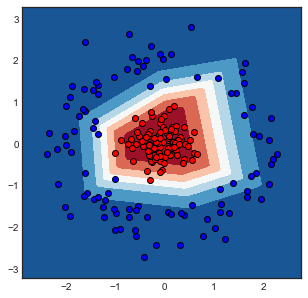

Epoch no. 261
accuracy: 1.0000
loss: 0.0914
Epoch no. 262
accuracy: 1.0000
loss: 0.0908
Epoch no. 263
accuracy: 1.0000
loss: 0.0903
Epoch no. 264
accuracy: 1.0000
loss: 0.0898
Epoch no. 265
accuracy: 1.0000
loss: 0.0892


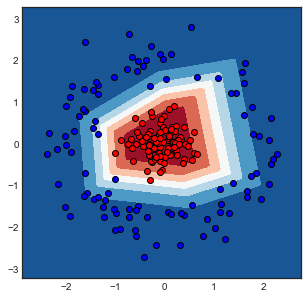

Epoch no. 266
accuracy: 1.0000
loss: 0.0887
Epoch no. 267
accuracy: 1.0000
loss: 0.0882
Epoch no. 268
accuracy: 1.0000
loss: 0.0877
Epoch no. 269
accuracy: 1.0000
loss: 0.0872
Epoch no. 270
accuracy: 1.0000
loss: 0.0867


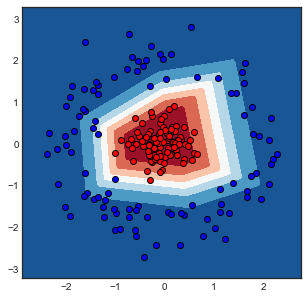

Epoch no. 271
accuracy: 1.0000
loss: 0.0862
Epoch no. 272
accuracy: 1.0000
loss: 0.0857
Epoch no. 273
accuracy: 1.0000
loss: 0.0853
Epoch no. 274
accuracy: 1.0000
loss: 0.0848
Epoch no. 275
accuracy: 1.0000
loss: 0.0843


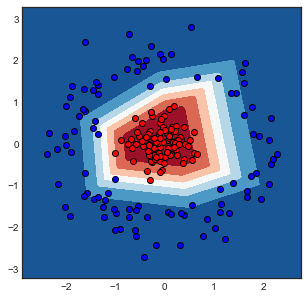

Epoch no. 276
accuracy: 1.0000
loss: 0.0839
Epoch no. 277
accuracy: 1.0000
loss: 0.0834
Epoch no. 278
accuracy: 1.0000
loss: 0.0830
Epoch no. 279
accuracy: 1.0000
loss: 0.0825
Epoch no. 280
accuracy: 1.0000
loss: 0.0821


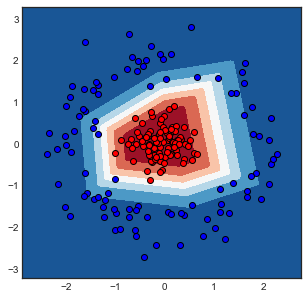

Epoch no. 281
accuracy: 1.0000
loss: 0.0816
Epoch no. 282
accuracy: 1.0000
loss: 0.0812
Epoch no. 283
accuracy: 1.0000
loss: 0.0808
Epoch no. 284
accuracy: 1.0000
loss: 0.0804
Epoch no. 285
accuracy: 1.0000
loss: 0.0799


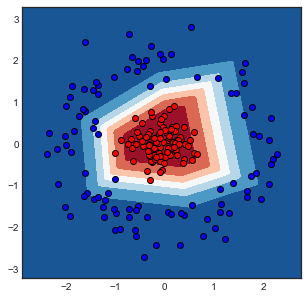

Epoch no. 286
accuracy: 1.0000
loss: 0.0795
Epoch no. 287
accuracy: 1.0000
loss: 0.0791
Epoch no. 288
accuracy: 1.0000
loss: 0.0787
Epoch no. 289
accuracy: 1.0000
loss: 0.0783
Epoch no. 290
accuracy: 1.0000
loss: 0.0779


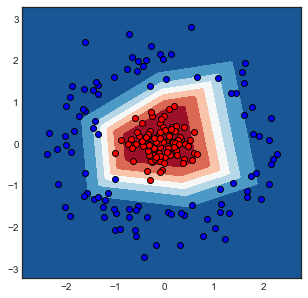

Epoch no. 291
accuracy: 1.0000
loss: 0.0775
Epoch no. 292
accuracy: 1.0000
loss: 0.0771
Epoch no. 293
accuracy: 1.0000
loss: 0.0767
Epoch no. 294
accuracy: 1.0000
loss: 0.0764
Epoch no. 295
accuracy: 1.0000
loss: 0.0760


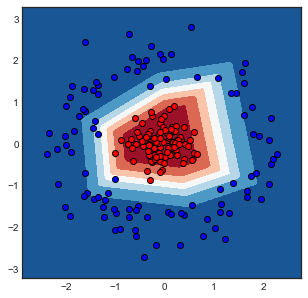

Epoch no. 296
accuracy: 1.0000
loss: 0.0756
Epoch no. 297
accuracy: 1.0000
loss: 0.0753
Epoch no. 298
accuracy: 1.0000
loss: 0.0749
Epoch no. 299
accuracy: 1.0000
loss: 0.0745


In [11]:



net = Net(layers=[Linear(2, 4), ReLU(), Linear(4, 2)],
          loss=CrossEntropyLoss())

n_epochs = 300

loss_val, acc_val = [], []

for epoch_idx in range(n_epochs):
    print("Epoch no. %d" % epoch_idx)
    out = net(X)
    # prediction accuracy
    pred = np.argmax(out, axis=1)
    print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels).sum()/200))
    loss = net.loss(out, Y_labels)
    print('loss: %1.4f' % loss)
    grad = net.backward()
    net.update_weights(lr=0.1)
    
    acc = 1 - np.abs(pred - Y_labels).sum()/200
    loss_val.append(loss)
    acc_val.append(acc)
    
    if epoch_idx % 5 == 0:
        plot_classifier(net, X, x_meshgrid, y_meshgrid, X_grid)

In [12]:
##plt.plot??

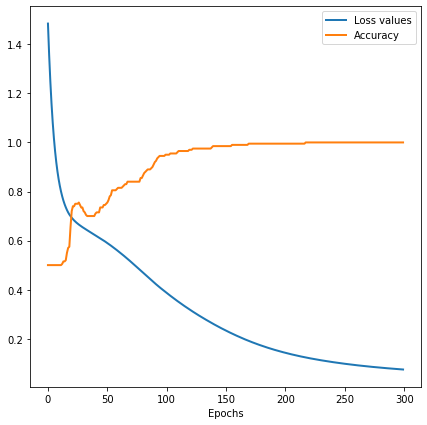

In [13]:
plt.figure(figsize=(7, 7))
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(loss_val), linewidth=2, label='Loss values' )
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(acc_val), linewidth=2, label='Accuracy' )
plt.xlabel('Epochs')
plt.legend()

In [14]:
x_meshgrid.shape

(100, 100)

In [15]:
X.shape, Y_labels.shape

((200, 2), (200,))

In [16]:
net.layers[0]

### Generating a new random data point and see prediction on that

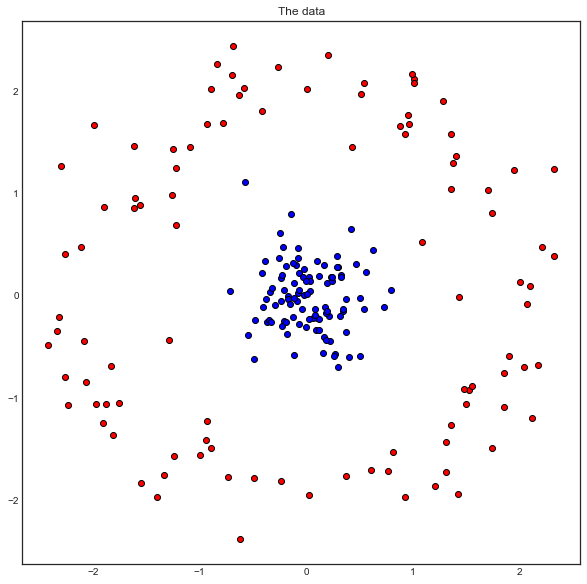

In [17]:
# generating some data
n_class_size = 100
r = 2
X1_offset = np.random.rand(n_class_size, 2) - 0.5
np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1_offset = r * X1_offset/np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size) + X1_offset
X2 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size)

X_test = np.concatenate((X1, X2))
Y_labels_test = np.array([0]*n_class_size + [1]*n_class_size)

plot_data(X1, X2)
# make meshgrid
x_meshgrid, y_meshgrid, X_grid = make_grid(X_test, n_res=100)

In [18]:
out = net(X_test)
pred = np.argmax(out, axis=1)

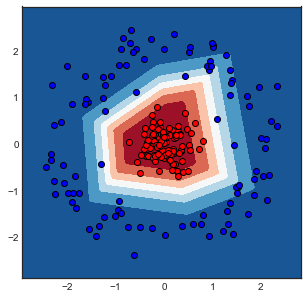

accuracy: 0.9950


In [19]:
plot_classifier(net, X_test, x_meshgrid, y_meshgrid, X_grid)
print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels_test).sum()/200))

### Lets try a deeper network

Epoch no. 0
accuracy: 0.5000
loss: 0.8091


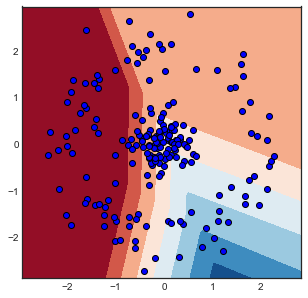

Epoch no. 1
accuracy: 0.5000
loss: 0.7921
Epoch no. 2
accuracy: 0.5000
loss: 0.7776
Epoch no. 3
accuracy: 0.5000
loss: 0.7652
Epoch no. 4
accuracy: 0.5000
loss: 0.7548
Epoch no. 5
accuracy: 0.5000
loss: 0.7458


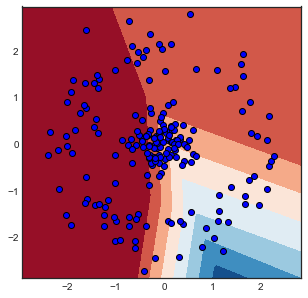

Epoch no. 6
accuracy: 0.5000
loss: 0.7381
Epoch no. 7
accuracy: 0.5000
loss: 0.7312
Epoch no. 8
accuracy: 0.5000
loss: 0.7254
Epoch no. 9
accuracy: 0.5000
loss: 0.7204
Epoch no. 10
accuracy: 0.5000
loss: 0.7163


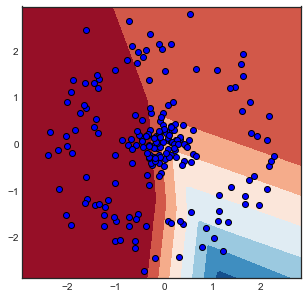

Epoch no. 11
accuracy: 0.5000
loss: 0.7129
Epoch no. 12
accuracy: 0.5000
loss: 0.7101
Epoch no. 13
accuracy: 0.5000
loss: 0.7075
Epoch no. 14
accuracy: 0.5000
loss: 0.7054
Epoch no. 15
accuracy: 0.5000
loss: 0.7036


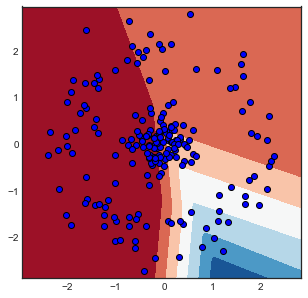

Epoch no. 16
accuracy: 0.5000
loss: 0.7021
Epoch no. 17
accuracy: 0.5000
loss: 0.7007
Epoch no. 18
accuracy: 0.5000
loss: 0.6995
Epoch no. 19
accuracy: 0.5000
loss: 0.6985
Epoch no. 20
accuracy: 0.5000
loss: 0.6975


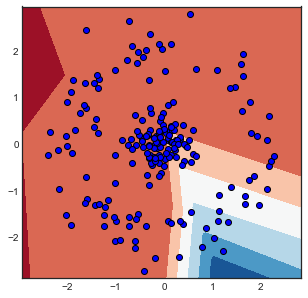

Epoch no. 21
accuracy: 0.5000
loss: 0.6968
Epoch no. 22
accuracy: 0.5000
loss: 0.6960
Epoch no. 23
accuracy: 0.5000
loss: 0.6954
Epoch no. 24
accuracy: 0.5000
loss: 0.6948
Epoch no. 25
accuracy: 0.5000
loss: 0.6943


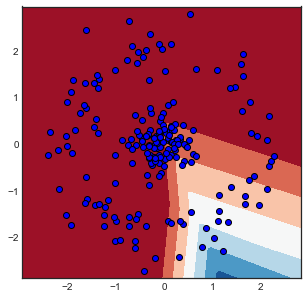

Epoch no. 26
accuracy: 0.5000
loss: 0.6939
Epoch no. 27
accuracy: 0.5000
loss: 0.6935
Epoch no. 28
accuracy: 0.5000
loss: 0.6931
Epoch no. 29
accuracy: 0.5000
loss: 0.6927
Epoch no. 30
accuracy: 0.5000
loss: 0.6924


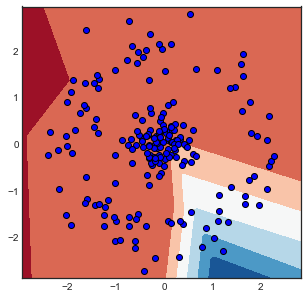

Epoch no. 31
accuracy: 0.5000
loss: 0.6922
Epoch no. 32
accuracy: 0.5000
loss: 0.6919
Epoch no. 33
accuracy: 0.5000
loss: 0.6917
Epoch no. 34
accuracy: 0.5000
loss: 0.6912
Epoch no. 35
accuracy: 0.5000
loss: 0.6908


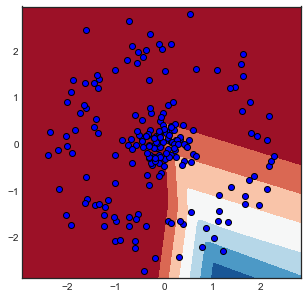

Epoch no. 36
accuracy: 0.5000
loss: 0.6904
Epoch no. 37
accuracy: 0.5000
loss: 0.6901
Epoch no. 38
accuracy: 0.5000
loss: 0.6897
Epoch no. 39
accuracy: 0.5000
loss: 0.6894
Epoch no. 40
accuracy: 0.5000
loss: 0.6892


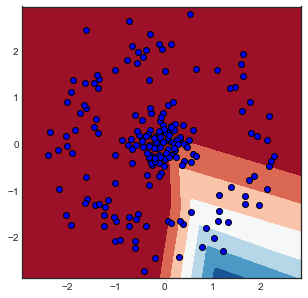

Epoch no. 41
accuracy: 0.5000
loss: 0.6889
Epoch no. 42
accuracy: 0.5000
loss: 0.6887
Epoch no. 43
accuracy: 0.5000
loss: 0.6884
Epoch no. 44
accuracy: 0.5000
loss: 0.6882
Epoch no. 45
accuracy: 0.5000
loss: 0.6880


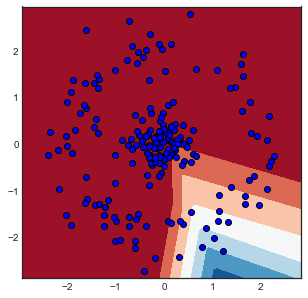

Epoch no. 46
accuracy: 0.5000
loss: 0.6878
Epoch no. 47
accuracy: 0.5000
loss: 0.6877
Epoch no. 48
accuracy: 0.5000
loss: 0.6875
Epoch no. 49
accuracy: 0.5000
loss: 0.6873
Epoch no. 50
accuracy: 0.5000
loss: 0.6871


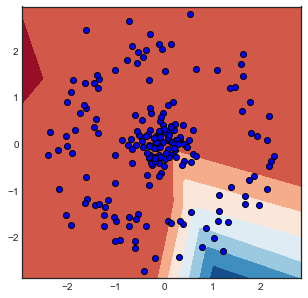

Epoch no. 51
accuracy: 0.5000
loss: 0.6869
Epoch no. 52
accuracy: 0.5000
loss: 0.6867
Epoch no. 53
accuracy: 0.5000
loss: 0.6865
Epoch no. 54
accuracy: 0.5000
loss: 0.6863
Epoch no. 55
accuracy: 0.5000
loss: 0.6861


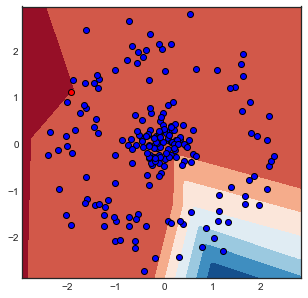

Epoch no. 56
accuracy: 0.4950
loss: 0.6859
Epoch no. 57
accuracy: 0.4850
loss: 0.6858
Epoch no. 58
accuracy: 0.4750
loss: 0.6856
Epoch no. 59
accuracy: 0.4750
loss: 0.6854
Epoch no. 60
accuracy: 0.4800
loss: 0.6852


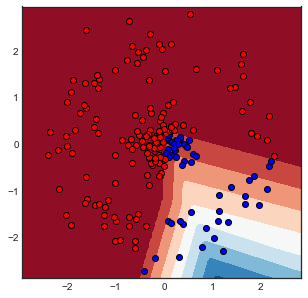

Epoch no. 61
accuracy: 0.4800
loss: 0.6850
Epoch no. 62
accuracy: 0.4800
loss: 0.6847
Epoch no. 63
accuracy: 0.4850
loss: 0.6845
Epoch no. 64
accuracy: 0.4850
loss: 0.6843
Epoch no. 65
accuracy: 0.4900
loss: 0.6840


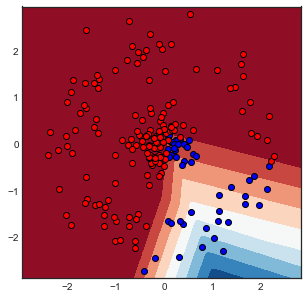

Epoch no. 66
accuracy: 0.4900
loss: 0.6838
Epoch no. 67
accuracy: 0.5050
loss: 0.6835
Epoch no. 68
accuracy: 0.5050
loss: 0.6833
Epoch no. 69
accuracy: 0.5100
loss: 0.6831
Epoch no. 70
accuracy: 0.5100
loss: 0.6828


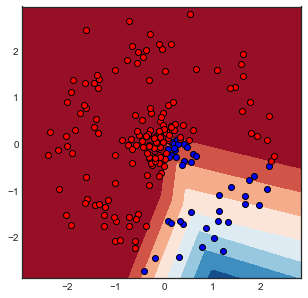

Epoch no. 71
accuracy: 0.5100
loss: 0.6826
Epoch no. 72
accuracy: 0.5100
loss: 0.6823
Epoch no. 73
accuracy: 0.5150
loss: 0.6821
Epoch no. 74
accuracy: 0.5200
loss: 0.6818
Epoch no. 75
accuracy: 0.5250
loss: 0.6815


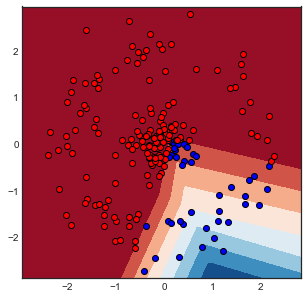

Epoch no. 76
accuracy: 0.5300
loss: 0.6811
Epoch no. 77
accuracy: 0.5400
loss: 0.6808
Epoch no. 78
accuracy: 0.5400
loss: 0.6804
Epoch no. 79
accuracy: 0.5400
loss: 0.6800
Epoch no. 80
accuracy: 0.5450
loss: 0.6796


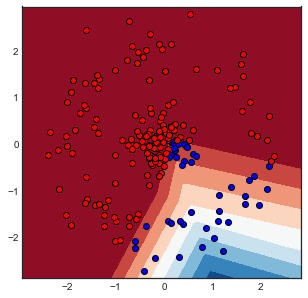

Epoch no. 81
accuracy: 0.5450
loss: 0.6792
Epoch no. 82
accuracy: 0.5400
loss: 0.6788
Epoch no. 83
accuracy: 0.5400
loss: 0.6785
Epoch no. 84
accuracy: 0.5400
loss: 0.6780
Epoch no. 85
accuracy: 0.5350
loss: 0.6776


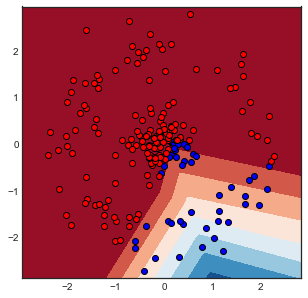

Epoch no. 86
accuracy: 0.5350
loss: 0.6772
Epoch no. 87
accuracy: 0.5350
loss: 0.6767
Epoch no. 88
accuracy: 0.5350
loss: 0.6760
Epoch no. 89
accuracy: 0.5350
loss: 0.6753
Epoch no. 90
accuracy: 0.5350
loss: 0.6745


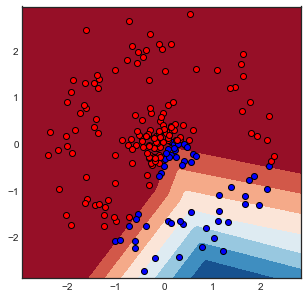

Epoch no. 91
accuracy: 0.5400
loss: 0.6737
Epoch no. 92
accuracy: 0.5450
loss: 0.6728
Epoch no. 93
accuracy: 0.5450
loss: 0.6720
Epoch no. 94
accuracy: 0.5450
loss: 0.6712
Epoch no. 95
accuracy: 0.5450
loss: 0.6703


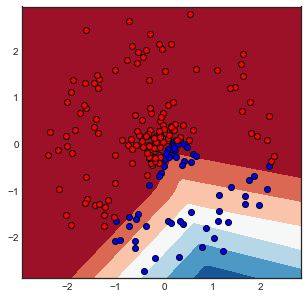

Epoch no. 96
accuracy: 0.5450
loss: 0.6694
Epoch no. 97
accuracy: 0.5400
loss: 0.6683
Epoch no. 98
accuracy: 0.5500
loss: 0.6672
Epoch no. 99
accuracy: 0.5650
loss: 0.6661
Epoch no. 100
accuracy: 0.5650
loss: 0.6651


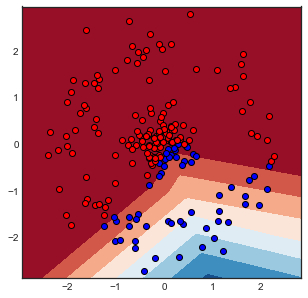

Epoch no. 101
accuracy: 0.5700
loss: 0.6640
Epoch no. 102
accuracy: 0.5750
loss: 0.6629
Epoch no. 103
accuracy: 0.5750
loss: 0.6618
Epoch no. 104
accuracy: 0.5900
loss: 0.6606
Epoch no. 105
accuracy: 0.5900
loss: 0.6594


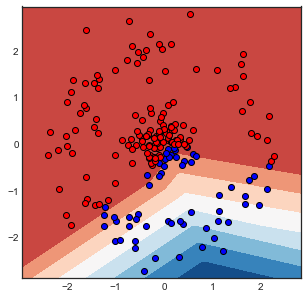

Epoch no. 106
accuracy: 0.5900
loss: 0.6578
Epoch no. 107
accuracy: 0.6000
loss: 0.6561
Epoch no. 108
accuracy: 0.6100
loss: 0.6544
Epoch no. 109
accuracy: 0.6050
loss: 0.6526
Epoch no. 110
accuracy: 0.6050
loss: 0.6505


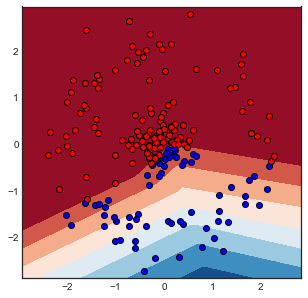

Epoch no. 111
accuracy: 0.6100
loss: 0.6483
Epoch no. 112
accuracy: 0.6050
loss: 0.6461
Epoch no. 113
accuracy: 0.6050
loss: 0.6439
Epoch no. 114
accuracy: 0.6050
loss: 0.6418
Epoch no. 115
accuracy: 0.6100
loss: 0.6397


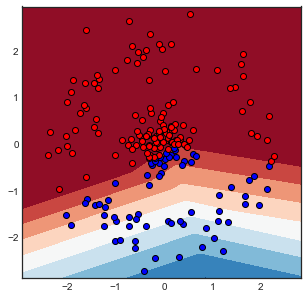

Epoch no. 116
accuracy: 0.6100
loss: 0.6377
Epoch no. 117
accuracy: 0.6100
loss: 0.6358
Epoch no. 118
accuracy: 0.6100
loss: 0.6336
Epoch no. 119
accuracy: 0.6150
loss: 0.6315
Epoch no. 120
accuracy: 0.6200
loss: 0.6293


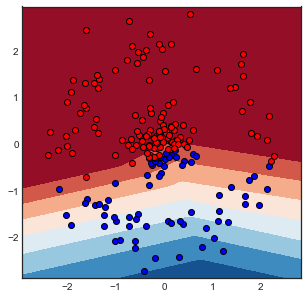

Epoch no. 121
accuracy: 0.6200
loss: 0.6272
Epoch no. 122
accuracy: 0.6200
loss: 0.6250
Epoch no. 123
accuracy: 0.6200
loss: 0.6230
Epoch no. 124
accuracy: 0.6250
loss: 0.6209
Epoch no. 125
accuracy: 0.6300
loss: 0.6190


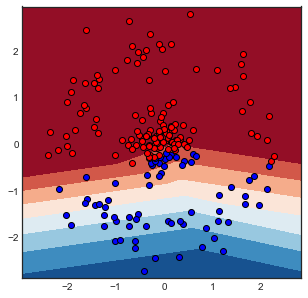

Epoch no. 126
accuracy: 0.6300
loss: 0.6170
Epoch no. 127
accuracy: 0.6350
loss: 0.6151
Epoch no. 128
accuracy: 0.6400
loss: 0.6132
Epoch no. 129
accuracy: 0.6350
loss: 0.6113
Epoch no. 130
accuracy: 0.6400
loss: 0.6095


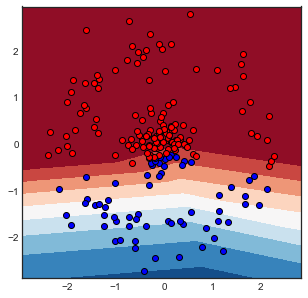

Epoch no. 131
accuracy: 0.6400
loss: 0.6076
Epoch no. 132
accuracy: 0.6400
loss: 0.6059
Epoch no. 133
accuracy: 0.6450
loss: 0.6041
Epoch no. 134
accuracy: 0.6550
loss: 0.6024
Epoch no. 135
accuracy: 0.6550
loss: 0.6007


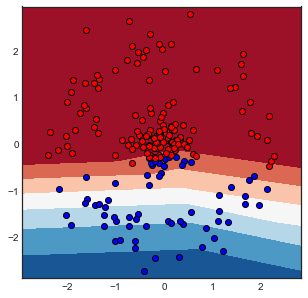

Epoch no. 136
accuracy: 0.6550
loss: 0.5991
Epoch no. 137
accuracy: 0.6550
loss: 0.5975
Epoch no. 138
accuracy: 0.6550
loss: 0.5960
Epoch no. 139
accuracy: 0.6600
loss: 0.5945
Epoch no. 140
accuracy: 0.6650
loss: 0.5931


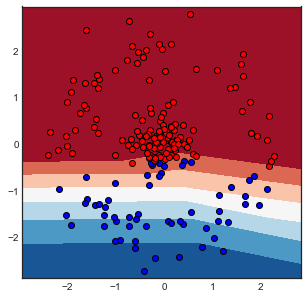

Epoch no. 141
accuracy: 0.6750
loss: 0.5917
Epoch no. 142
accuracy: 0.6750
loss: 0.5903
Epoch no. 143
accuracy: 0.6750
loss: 0.5889
Epoch no. 144
accuracy: 0.6750
loss: 0.5875
Epoch no. 145
accuracy: 0.6750
loss: 0.5861


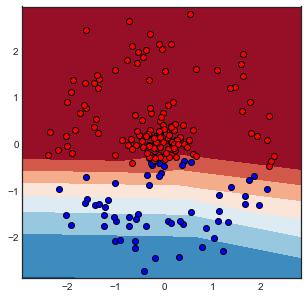

Epoch no. 146
accuracy: 0.6750
loss: 0.5848
Epoch no. 147
accuracy: 0.6800
loss: 0.5835
Epoch no. 148
accuracy: 0.6800
loss: 0.5822
Epoch no. 149
accuracy: 0.6800
loss: 0.5809
Epoch no. 150
accuracy: 0.6800
loss: 0.5797


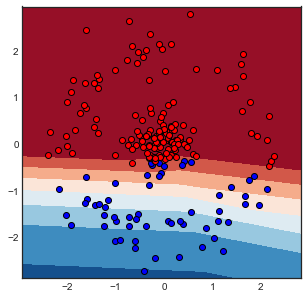

Epoch no. 151
accuracy: 0.6800
loss: 0.5784
Epoch no. 152
accuracy: 0.6800
loss: 0.5772
Epoch no. 153
accuracy: 0.6850
loss: 0.5760
Epoch no. 154
accuracy: 0.6900
loss: 0.5749
Epoch no. 155
accuracy: 0.6900
loss: 0.5737


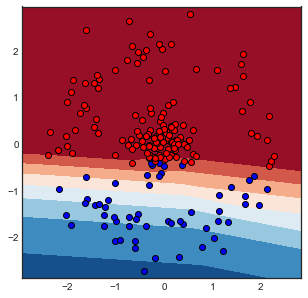

Epoch no. 156
accuracy: 0.6900
loss: 0.5726
Epoch no. 157
accuracy: 0.6900
loss: 0.5714
Epoch no. 158
accuracy: 0.6900
loss: 0.5703
Epoch no. 159
accuracy: 0.6900
loss: 0.5692
Epoch no. 160
accuracy: 0.6900
loss: 0.5682


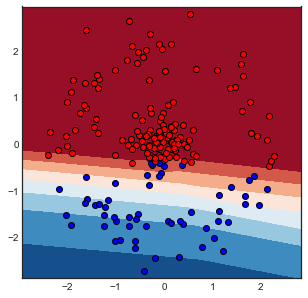

Epoch no. 161
accuracy: 0.6900
loss: 0.5672
Epoch no. 162
accuracy: 0.7000
loss: 0.5662
Epoch no. 163
accuracy: 0.7000
loss: 0.5653
Epoch no. 164
accuracy: 0.7000
loss: 0.5644
Epoch no. 165
accuracy: 0.7050
loss: 0.5635


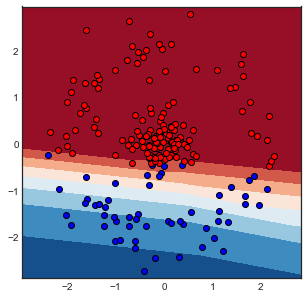

Epoch no. 166
accuracy: 0.7050
loss: 0.5626
Epoch no. 167
accuracy: 0.7050
loss: 0.5618
Epoch no. 168
accuracy: 0.7050
loss: 0.5609
Epoch no. 169
accuracy: 0.7000
loss: 0.5600
Epoch no. 170
accuracy: 0.7000
loss: 0.5592


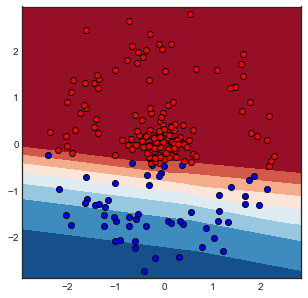

Epoch no. 171
accuracy: 0.7000
loss: 0.5583
Epoch no. 172
accuracy: 0.7000
loss: 0.5575
Epoch no. 173
accuracy: 0.7050
loss: 0.5567
Epoch no. 174
accuracy: 0.7050
loss: 0.5559
Epoch no. 175
accuracy: 0.7050
loss: 0.5552


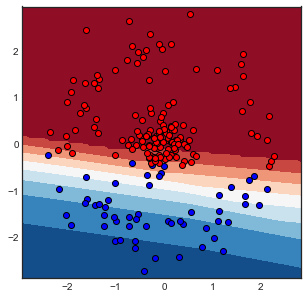

Epoch no. 176
accuracy: 0.7050
loss: 0.5544
Epoch no. 177
accuracy: 0.7050
loss: 0.5537
Epoch no. 178
accuracy: 0.7100
loss: 0.5530
Epoch no. 179
accuracy: 0.7100
loss: 0.5523
Epoch no. 180
accuracy: 0.7100
loss: 0.5516


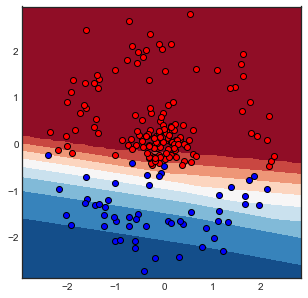

Epoch no. 181
accuracy: 0.7100
loss: 0.5509
Epoch no. 182
accuracy: 0.7150
loss: 0.5502
Epoch no. 183
accuracy: 0.7150
loss: 0.5495
Epoch no. 184
accuracy: 0.7150
loss: 0.5488
Epoch no. 185
accuracy: 0.7200
loss: 0.5482


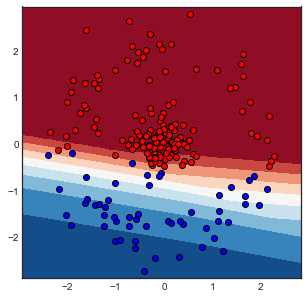

Epoch no. 186
accuracy: 0.7200
loss: 0.5475
Epoch no. 187
accuracy: 0.7200
loss: 0.5469
Epoch no. 188
accuracy: 0.7250
loss: 0.5463
Epoch no. 189
accuracy: 0.7250
loss: 0.5457
Epoch no. 190
accuracy: 0.7250
loss: 0.5451


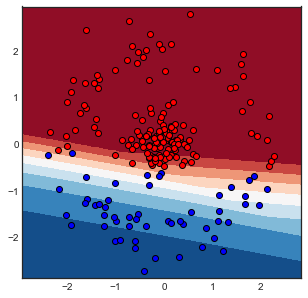

Epoch no. 191
accuracy: 0.7250
loss: 0.5445
Epoch no. 192
accuracy: 0.7250
loss: 0.5440
Epoch no. 193
accuracy: 0.7250
loss: 0.5435
Epoch no. 194
accuracy: 0.7300
loss: 0.5429
Epoch no. 195
accuracy: 0.7300
loss: 0.5424


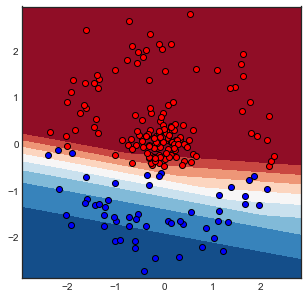

Epoch no. 196
accuracy: 0.7300
loss: 0.5419
Epoch no. 197
accuracy: 0.7300
loss: 0.5414
Epoch no. 198
accuracy: 0.7300
loss: 0.5409
Epoch no. 199
accuracy: 0.7300
loss: 0.5404
Epoch no. 200
accuracy: 0.7300
loss: 0.5400


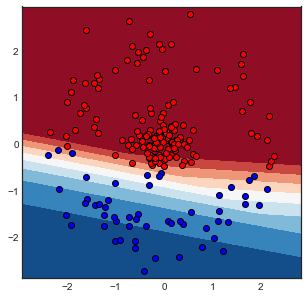

Epoch no. 201
accuracy: 0.7300
loss: 0.5395
Epoch no. 202
accuracy: 0.7300
loss: 0.5390
Epoch no. 203
accuracy: 0.7300
loss: 0.5386
Epoch no. 204
accuracy: 0.7300
loss: 0.5382
Epoch no. 205
accuracy: 0.7300
loss: 0.5377


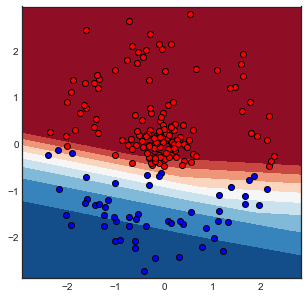

Epoch no. 206
accuracy: 0.7300
loss: 0.5373
Epoch no. 207
accuracy: 0.7300
loss: 0.5369
Epoch no. 208
accuracy: 0.7300
loss: 0.5365
Epoch no. 209
accuracy: 0.7300
loss: 0.5361
Epoch no. 210
accuracy: 0.7300
loss: 0.5357


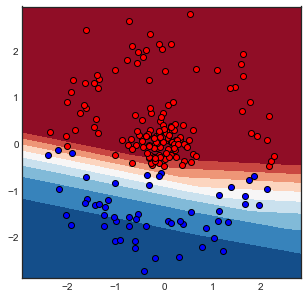

Epoch no. 211
accuracy: 0.7300
loss: 0.5353
Epoch no. 212
accuracy: 0.7300
loss: 0.5349
Epoch no. 213
accuracy: 0.7300
loss: 0.5345
Epoch no. 214
accuracy: 0.7300
loss: 0.5341
Epoch no. 215
accuracy: 0.7300
loss: 0.5338


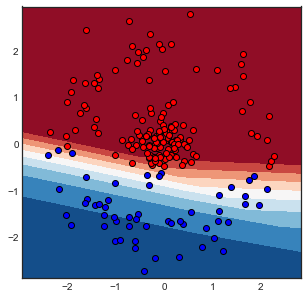

Epoch no. 216
accuracy: 0.7300
loss: 0.5334
Epoch no. 217
accuracy: 0.7300
loss: 0.5331
Epoch no. 218
accuracy: 0.7300
loss: 0.5327
Epoch no. 219
accuracy: 0.7300
loss: 0.5324
Epoch no. 220
accuracy: 0.7300
loss: 0.5321


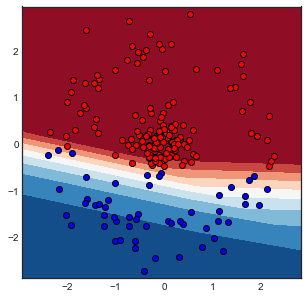

Epoch no. 221
accuracy: 0.7300
loss: 0.5317
Epoch no. 222
accuracy: 0.7300
loss: 0.5314
Epoch no. 223
accuracy: 0.7300
loss: 0.5311
Epoch no. 224
accuracy: 0.7300
loss: 0.5307
Epoch no. 225
accuracy: 0.7300
loss: 0.5304


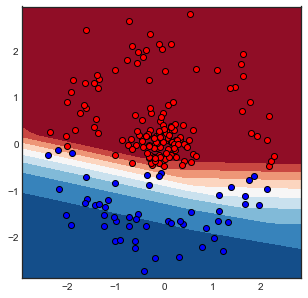

Epoch no. 226
accuracy: 0.7300
loss: 0.5301
Epoch no. 227
accuracy: 0.7300
loss: 0.5298
Epoch no. 228
accuracy: 0.7300
loss: 0.5294
Epoch no. 229
accuracy: 0.7300
loss: 0.5291
Epoch no. 230
accuracy: 0.7300
loss: 0.5288


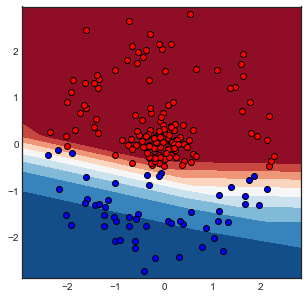

Epoch no. 231
accuracy: 0.7300
loss: 0.5285
Epoch no. 232
accuracy: 0.7300
loss: 0.5282
Epoch no. 233
accuracy: 0.7300
loss: 0.5279
Epoch no. 234
accuracy: 0.7300
loss: 0.5276
Epoch no. 235
accuracy: 0.7300
loss: 0.5272


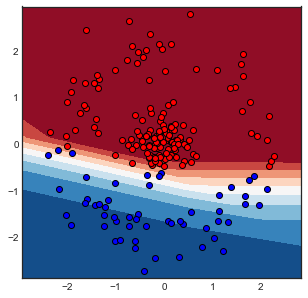

Epoch no. 236
accuracy: 0.7300
loss: 0.5269
Epoch no. 237
accuracy: 0.7300
loss: 0.5265
Epoch no. 238
accuracy: 0.7300
loss: 0.5260
Epoch no. 239
accuracy: 0.7300
loss: 0.5256
Epoch no. 240
accuracy: 0.7300
loss: 0.5252


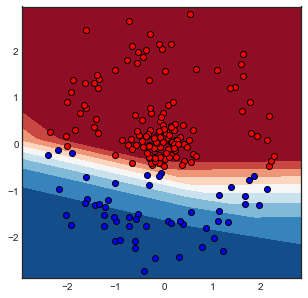

Epoch no. 241
accuracy: 0.7300
loss: 0.5248
Epoch no. 242
accuracy: 0.7300
loss: 0.5244
Epoch no. 243
accuracy: 0.7300
loss: 0.5240
Epoch no. 244
accuracy: 0.7250
loss: 0.5234
Epoch no. 245
accuracy: 0.7250
loss: 0.5229


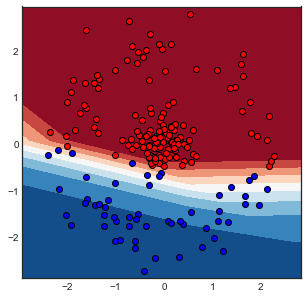

Epoch no. 246
accuracy: 0.7250
loss: 0.5224
Epoch no. 247
accuracy: 0.7250
loss: 0.5219
Epoch no. 248
accuracy: 0.7250
loss: 0.5214
Epoch no. 249
accuracy: 0.7250
loss: 0.5208
Epoch no. 250
accuracy: 0.7250
loss: 0.5203


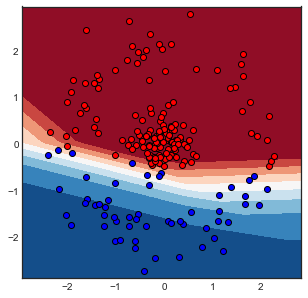

Epoch no. 251
accuracy: 0.7250
loss: 0.5198
Epoch no. 252
accuracy: 0.7250
loss: 0.5194
Epoch no. 253
accuracy: 0.7300
loss: 0.5189
Epoch no. 254
accuracy: 0.7300
loss: 0.5184
Epoch no. 255
accuracy: 0.7300
loss: 0.5179


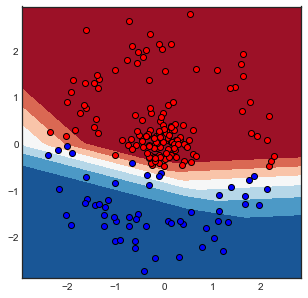

Epoch no. 256
accuracy: 0.7300
loss: 0.5172
Epoch no. 257
accuracy: 0.7350
loss: 0.5165
Epoch no. 258
accuracy: 0.7350
loss: 0.5158
Epoch no. 259
accuracy: 0.7350
loss: 0.5152
Epoch no. 260
accuracy: 0.7350
loss: 0.5145


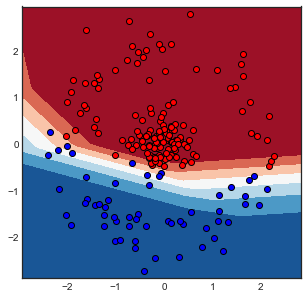

Epoch no. 261
accuracy: 0.7350
loss: 0.5137
Epoch no. 262
accuracy: 0.7350
loss: 0.5130
Epoch no. 263
accuracy: 0.7400
loss: 0.5123
Epoch no. 264
accuracy: 0.7450
loss: 0.5115
Epoch no. 265
accuracy: 0.7450
loss: 0.5108


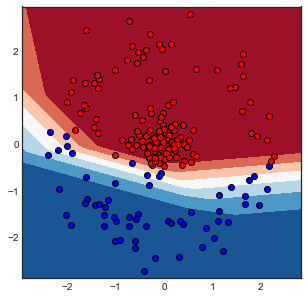

Epoch no. 266
accuracy: 0.7450
loss: 0.5101
Epoch no. 267
accuracy: 0.7450
loss: 0.5094
Epoch no. 268
accuracy: 0.7450
loss: 0.5085
Epoch no. 269
accuracy: 0.7450
loss: 0.5076
Epoch no. 270
accuracy: 0.7450
loss: 0.5067


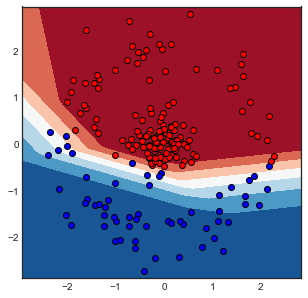

Epoch no. 271
accuracy: 0.7450
loss: 0.5056
Epoch no. 272
accuracy: 0.7450
loss: 0.5045
Epoch no. 273
accuracy: 0.7450
loss: 0.5031
Epoch no. 274
accuracy: 0.7450
loss: 0.5012
Epoch no. 275
accuracy: 0.7500
loss: 0.4988


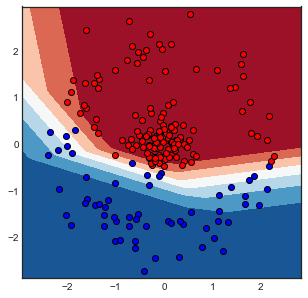

Epoch no. 276
accuracy: 0.7500
loss: 0.4960
Epoch no. 277
accuracy: 0.7550
loss: 0.4932
Epoch no. 278
accuracy: 0.7550
loss: 0.4903
Epoch no. 279
accuracy: 0.7500
loss: 0.4867
Epoch no. 280
accuracy: 0.7550
loss: 0.4825


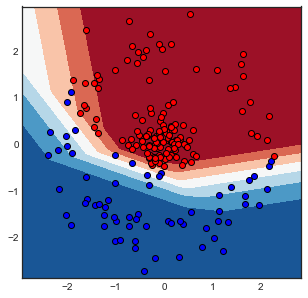

Epoch no. 281
accuracy: 0.7600
loss: 0.4787
Epoch no. 282
accuracy: 0.7700
loss: 0.4750
Epoch no. 283
accuracy: 0.7700
loss: 0.4716
Epoch no. 284
accuracy: 0.7900
loss: 0.4684
Epoch no. 285
accuracy: 0.7950
loss: 0.4654


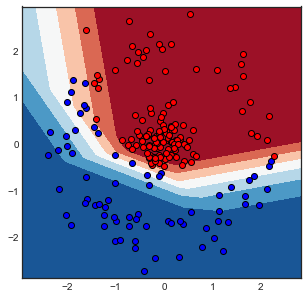

Epoch no. 286
accuracy: 0.7950
loss: 0.4624
Epoch no. 287
accuracy: 0.8000
loss: 0.4595
Epoch no. 288
accuracy: 0.8050
loss: 0.4567
Epoch no. 289
accuracy: 0.8050
loss: 0.4541
Epoch no. 290
accuracy: 0.8150
loss: 0.4516


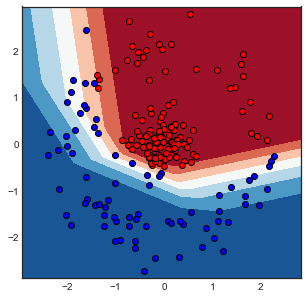

Epoch no. 291
accuracy: 0.8150
loss: 0.4492
Epoch no. 292
accuracy: 0.8250
loss: 0.4469
Epoch no. 293
accuracy: 0.8300
loss: 0.4447
Epoch no. 294
accuracy: 0.8300
loss: 0.4426
Epoch no. 295
accuracy: 0.8300
loss: 0.4406


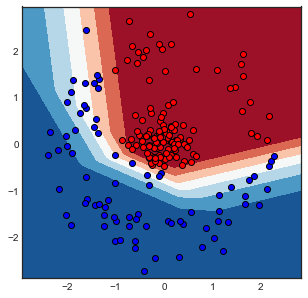

Epoch no. 296
accuracy: 0.8300
loss: 0.4385
Epoch no. 297
accuracy: 0.8300
loss: 0.4363
Epoch no. 298
accuracy: 0.8300
loss: 0.4342
Epoch no. 299
accuracy: 0.8300
loss: 0.4322


In [20]:
net2 = Net(layers=[Linear(2, 4), ReLU(), Linear(4, 4), ReLU(), Linear(4, 2) ],
          loss=CrossEntropyLoss())

n_epochs = 300

loss_val, acc_val = [], []

for epoch_idx in range(n_epochs):
    print("Epoch no. %d" % epoch_idx)
    out = net2(X)
    # prediction accuracy
    pred = np.argmax(out, axis=1)
    print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels).sum()/200))
    loss = net2.loss(out, Y_labels)
    print('loss: %1.4f' % loss)
    grad = net2.backward()
    net2.update_weights(lr=0.1)
    
    acc = 1 - np.abs(pred - Y_labels).sum()/200
    loss_val.append(loss)
    acc_val.append(acc)
    
    if epoch_idx % 5 == 0:
        plot_classifier(net2, X, x_meshgrid, y_meshgrid, X_grid)

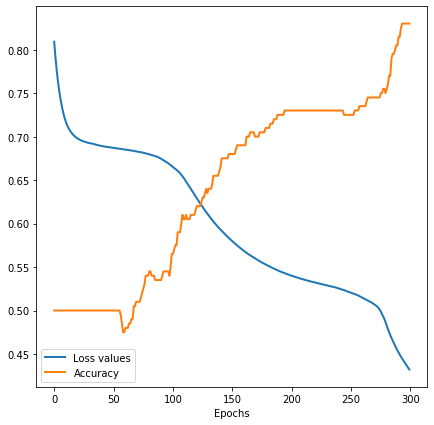

In [21]:
plt.figure(figsize=(7, 7))
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(loss_val), linewidth=2, label='Loss values' )
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(acc_val), linewidth=2, label='Accuracy' )
plt.xlabel('Epochs')
plt.legend()

In [22]:
out = net2(X_test)
pred = np.argmax(out, axis=1)

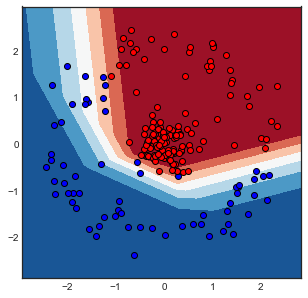

accuracy: 0.7900


In [23]:
plot_classifier(net2, X_test, x_meshgrid, y_meshgrid, X_grid)
print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels_test).sum()/200))